##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2.57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

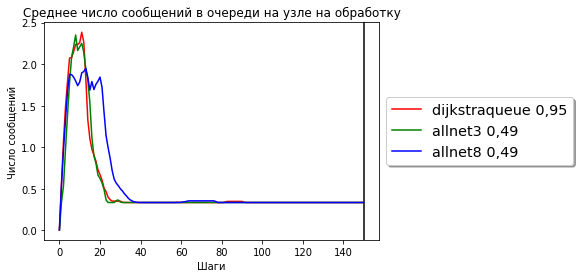

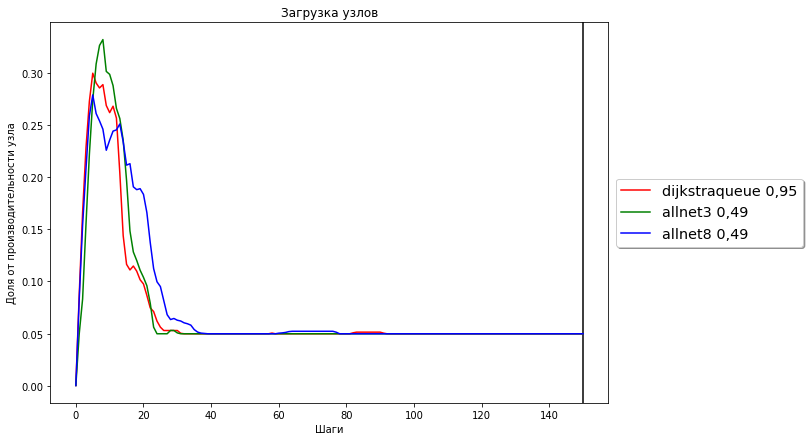

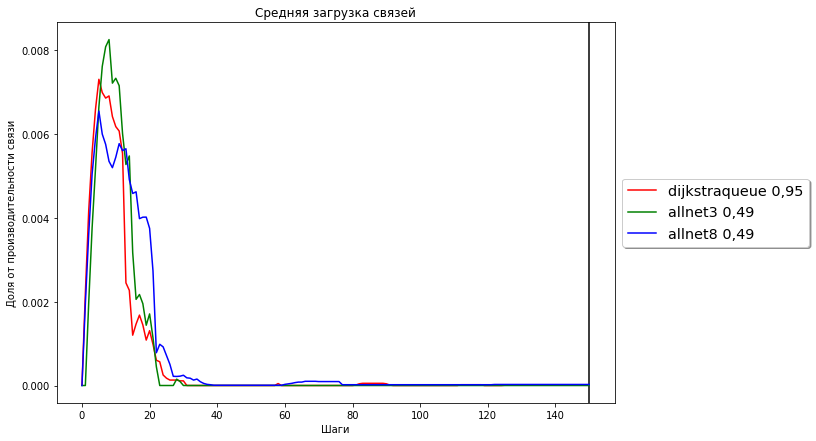

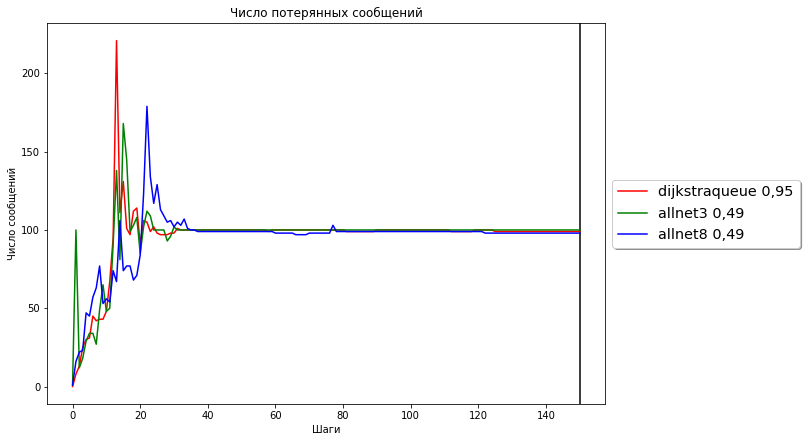

Доставлено 578 Потеряно 96.1469% -dijkstraqueue 0,95
Доставлено 502 Потеряно 96.6536% -allnet3 0,49
Доставлено 716 Потеряно 95.2270% -allnet8 0,49


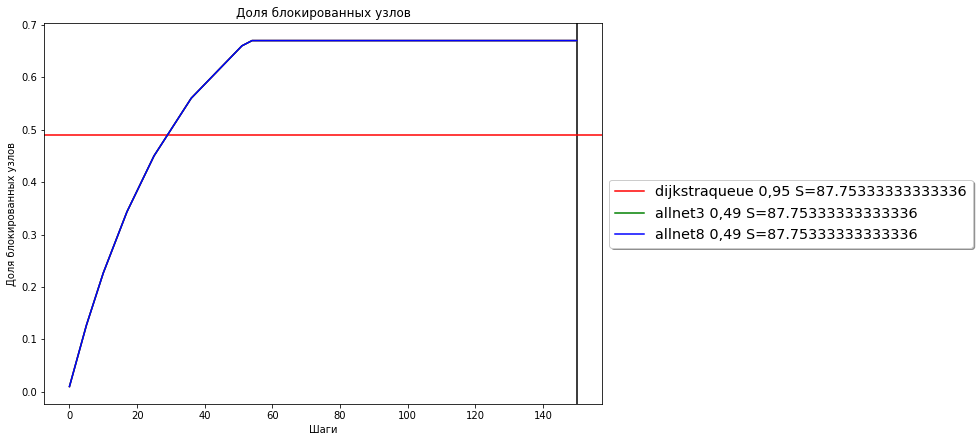

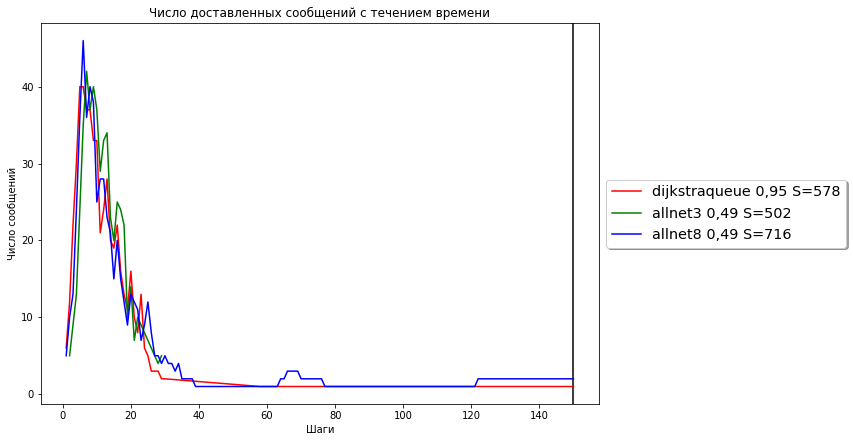

In [2]:
quantity = 100;
log_tags = [
{"tag":  "f96bcb8d-1e93-4ea7-8ea5-cd07d8cf8dbf", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d455dc19-d0a1-43c7-abd9-7bb4a472ff56", "label": "allnet3 0,49", "color": "green"},
{"tag":  "a39af52d-f2a2-453b-8919-91784a859a03", "label": "allnet8 0,49", "color": "blue"},

]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

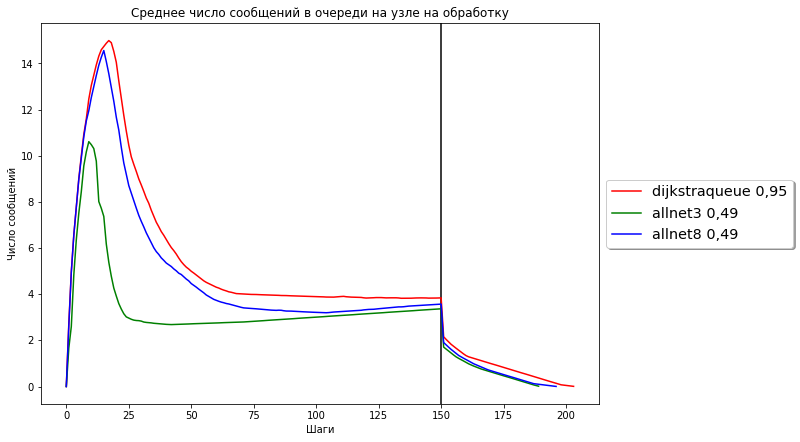

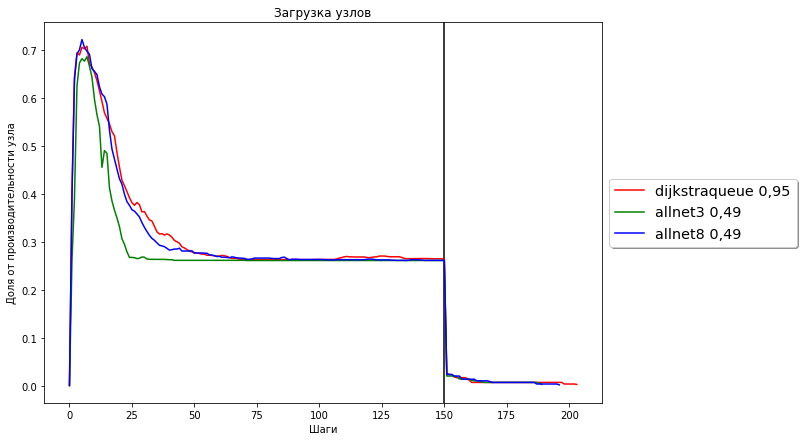

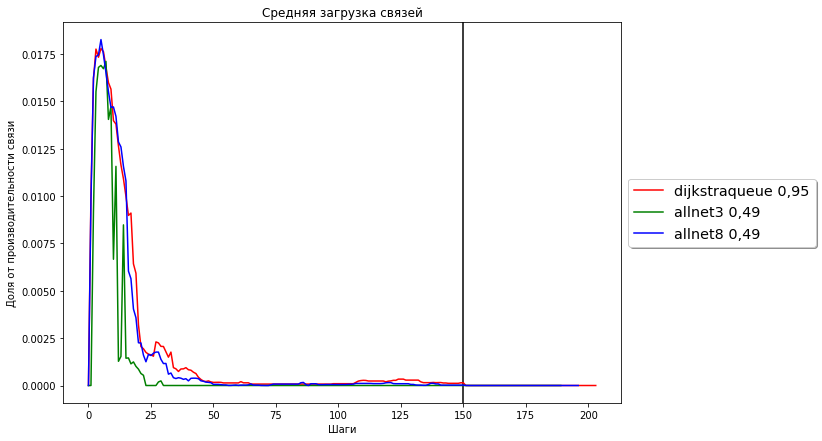

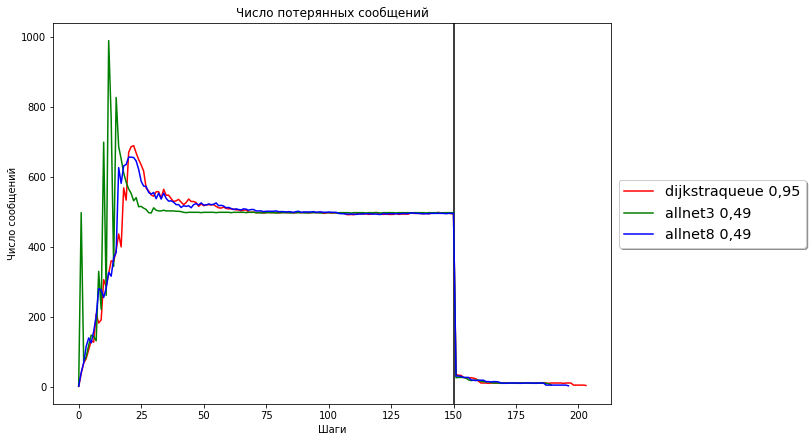

Доставлено 1811 Потеряно 97.5854% -dijkstraqueue 0,95
Доставлено 739 Потеряно 99.0147% -allnet3 0,49
Доставлено 1382 Потеряно 98.1574% -allnet8 0,49


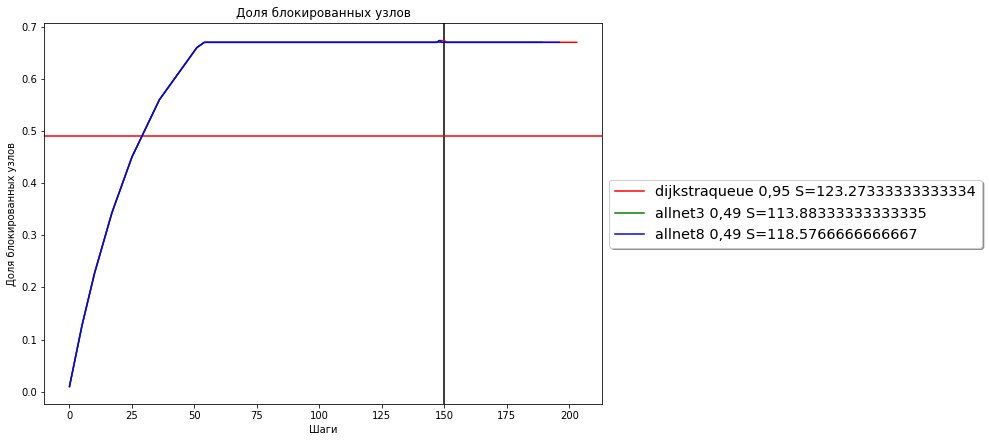

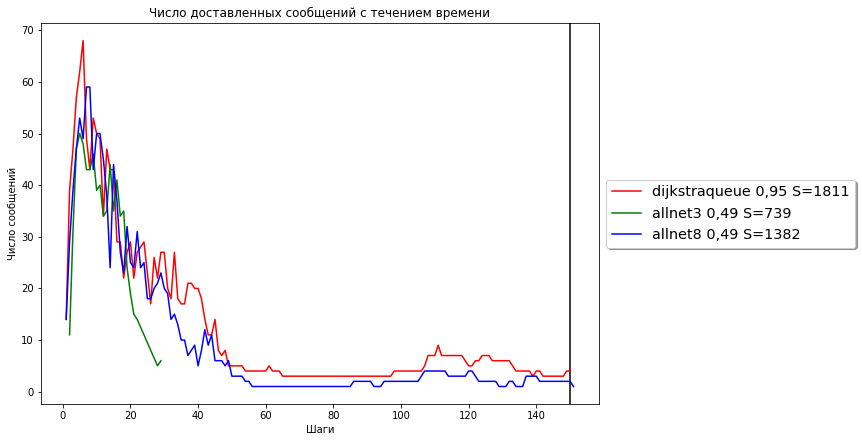

In [3]:
quantity = 500;
log_tags = [
{"tag":  "1c5fb336-f7be-4add-86a1-3725b09a518f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "dcb3913d-4e9a-451d-b1bc-a3427ee8917b", "label": "allnet3 0,49", "color": "green"},
{"tag":  "51b1cdb5-d4e4-442d-b4cf-de03e22dbc72", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

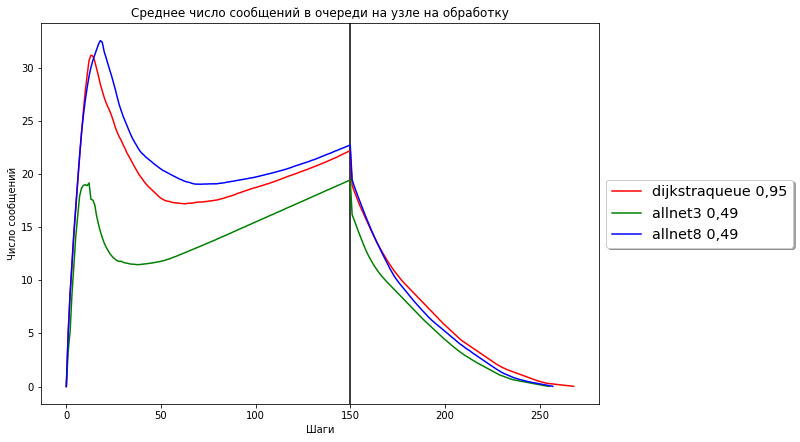

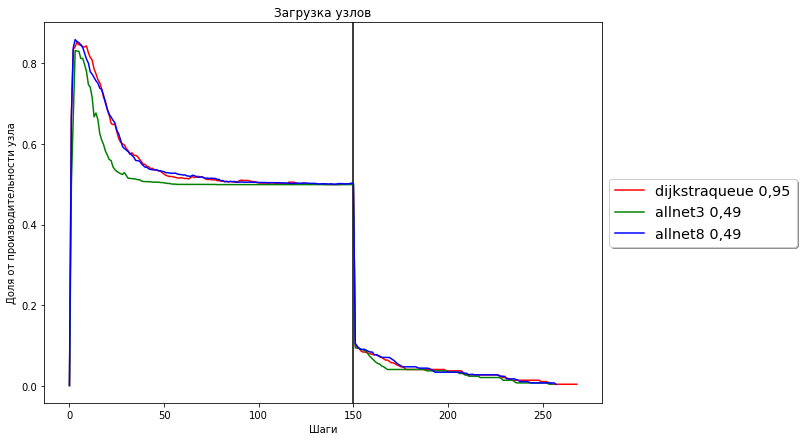

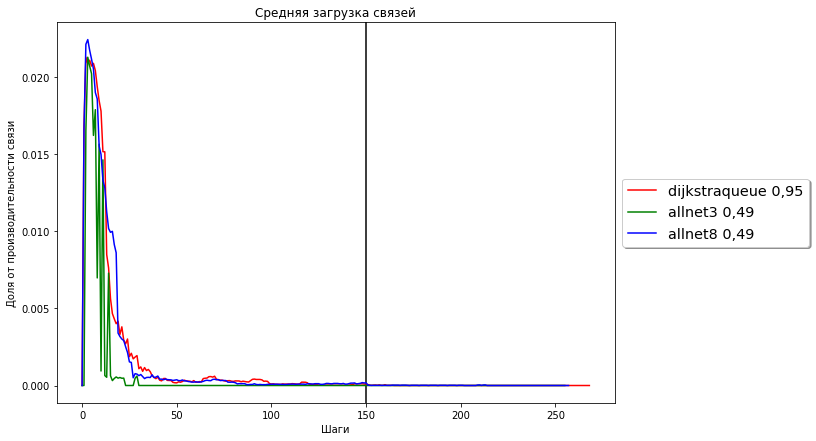

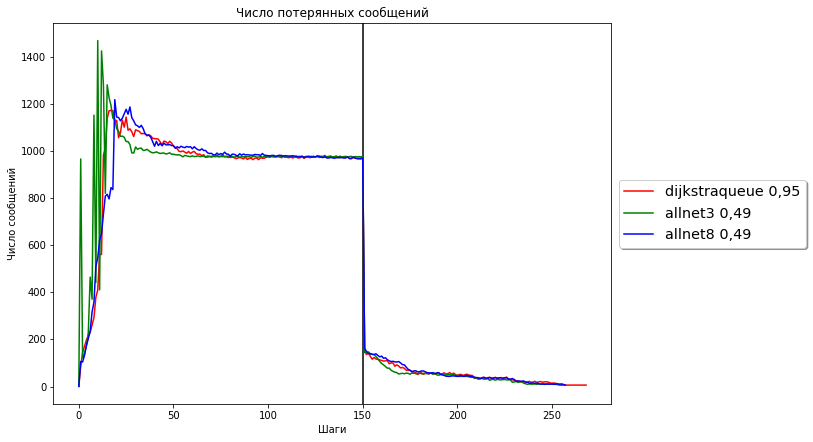

Доставлено 2138 Потеряно 98.5747% -dijkstraqueue 0,95
Доставлено 581 Потеряно 99.6127% -allnet3 0,49
Доставлено 2027 Потеряно 98.6487% -allnet8 0,49


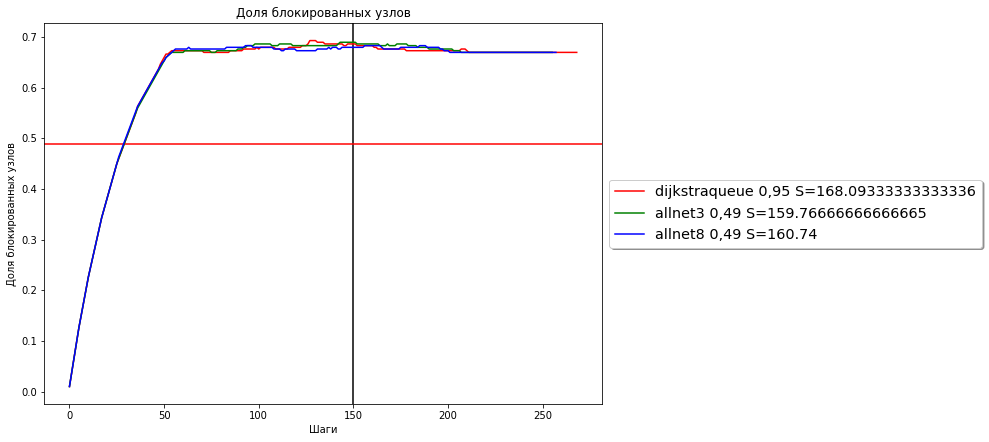

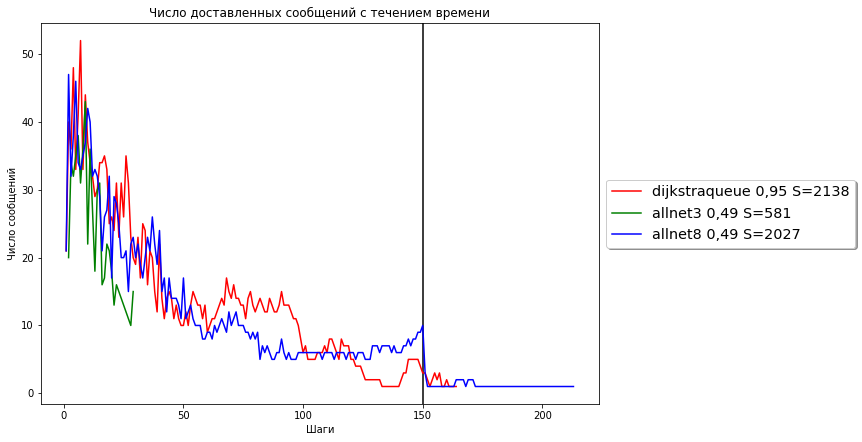

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "30763c85-7d7c-4357-ac80-07ac2d9142dc", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d1bea53d-c235-41dd-9f40-d3b5b08d3d40", "label": "allnet3 0,49", "color": "green"},
{"tag":  "50b49897-b518-4e19-a22c-ea6b48ed51de", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

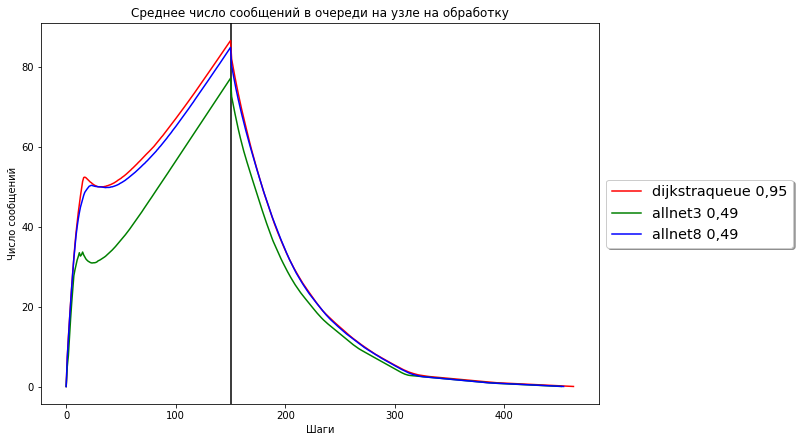

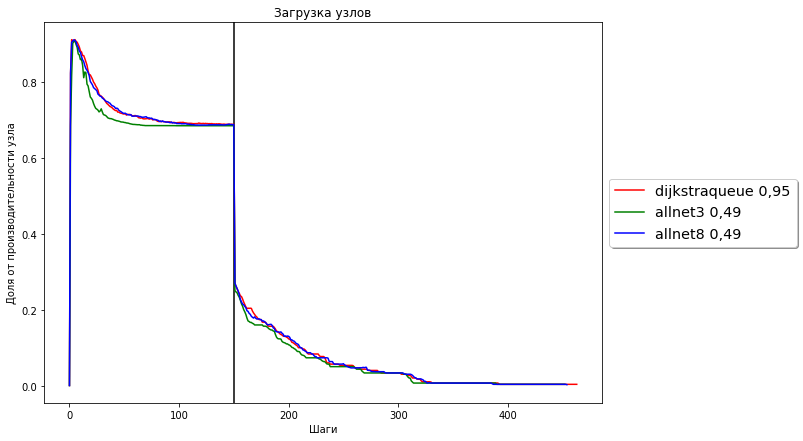

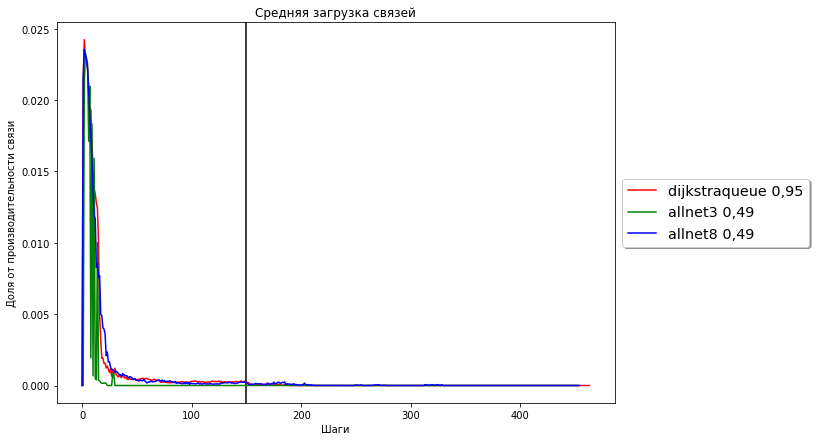

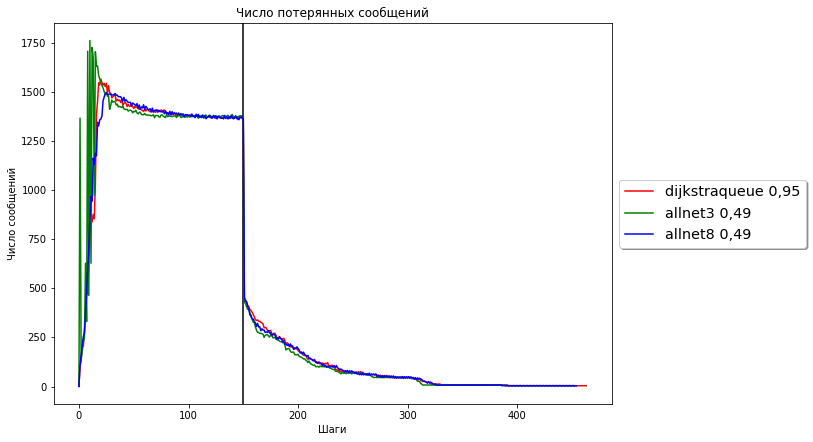

Доставлено 2343 Потеряно 98.9587% -dijkstraqueue 0,95
Доставлено 445 Потеряно 99.8022% -allnet3 0,49
Доставлено 2354 Потеряно 98.9538% -allnet8 0,49


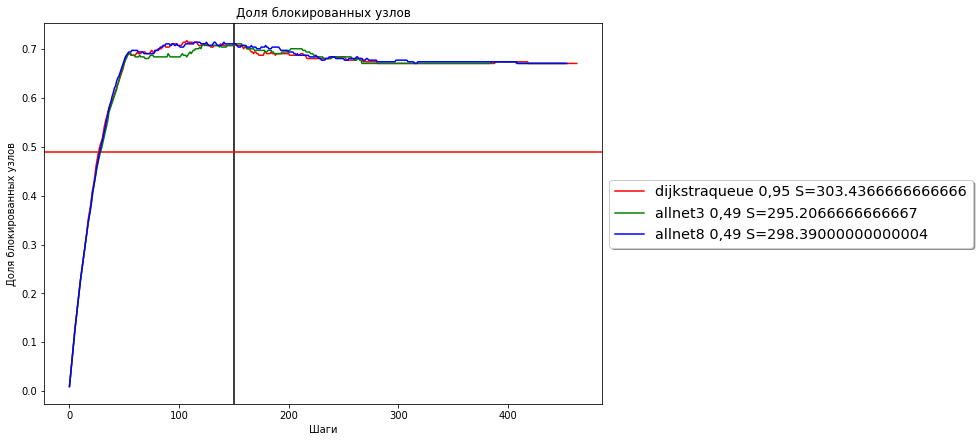

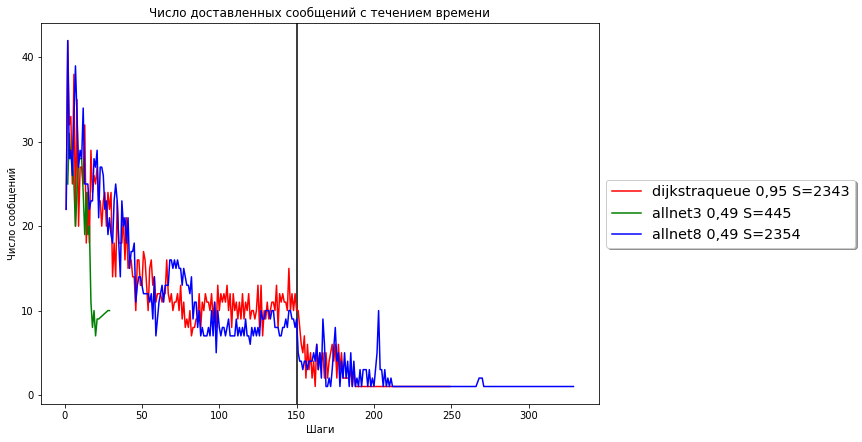

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "eb5e768c-c644-4a4b-b255-8d6021269862", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "3bdaaa0d-4f28-4e27-ac53-823530e5761d", "label": "allnet3 0,49", "color": "green"},
{"tag":  "81c19c1e-966a-4b3a-86a7-0e55d69a24c1", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 1095 Потеряно 97.5667% -dijkstraqueue 0,95
Доставлено 703 Потеряно 98.4378% -allnet3 0,49
Доставлено 1380 Потеряно 96.9334% -allnet8 0,49


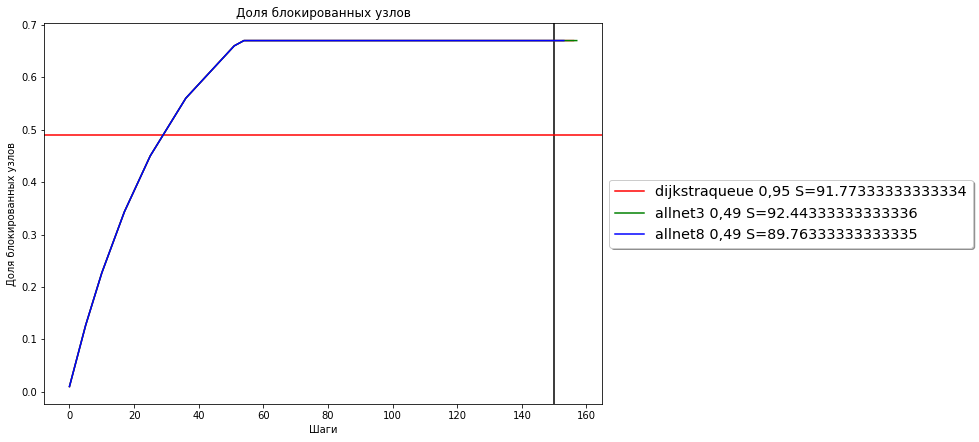

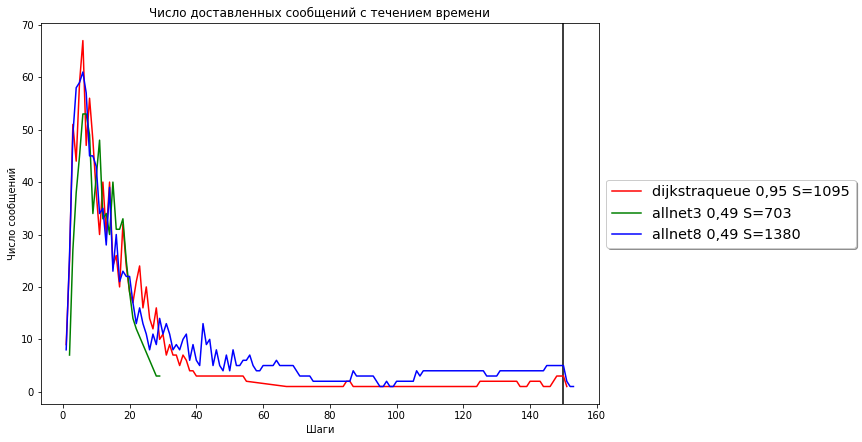

Доставлено 2197 Потеряно 97.9076% -dijkstraqueue 0,95
Доставлено 646 Потеряно 99.3848% -allnet3 0,49
Доставлено 2149 Потеряно 97.9534% -allnet8 0,49


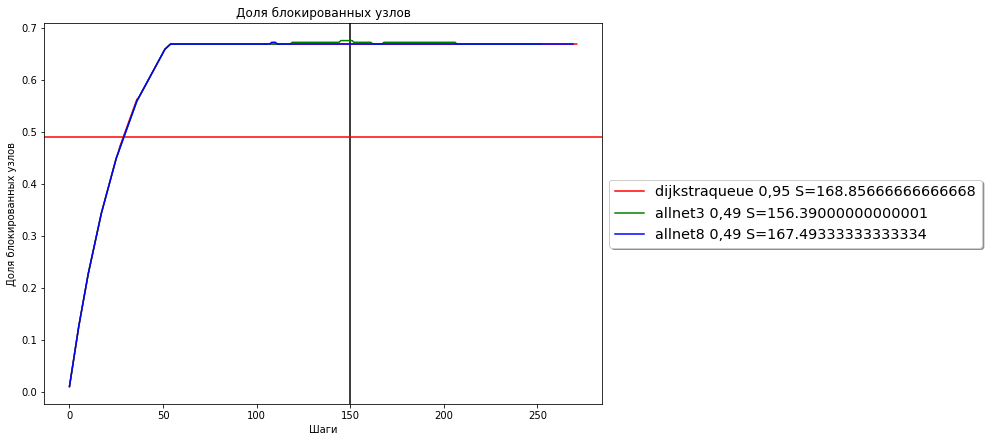

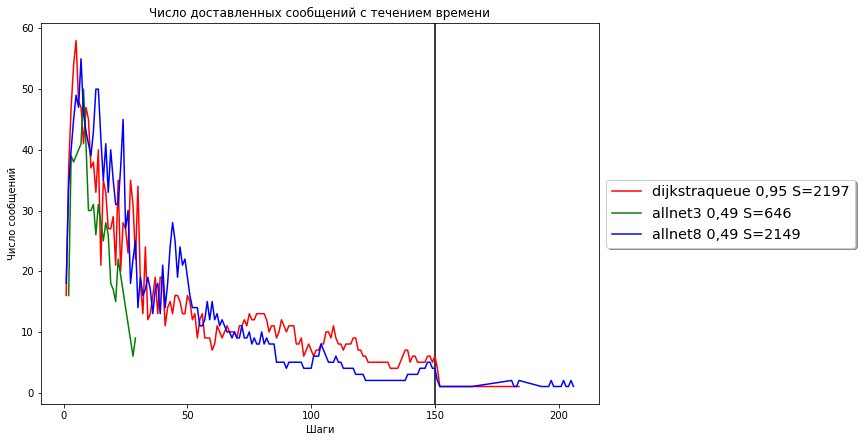

Доставлено 1979 Потеряно 98.5341% -dijkstraqueue 0,95
Доставлено 611 Потеряно 99.5474% -allnet3 0,49
Доставлено 1953 Потеряно 98.5533% -allnet8 0,49


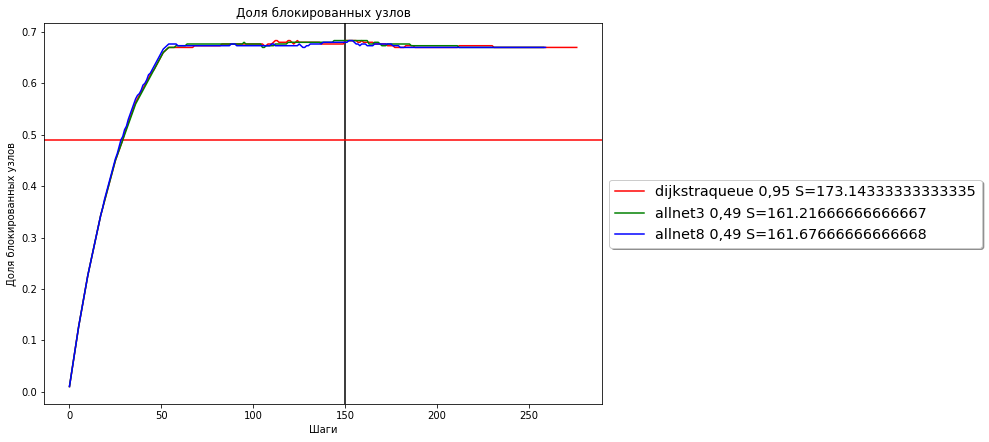

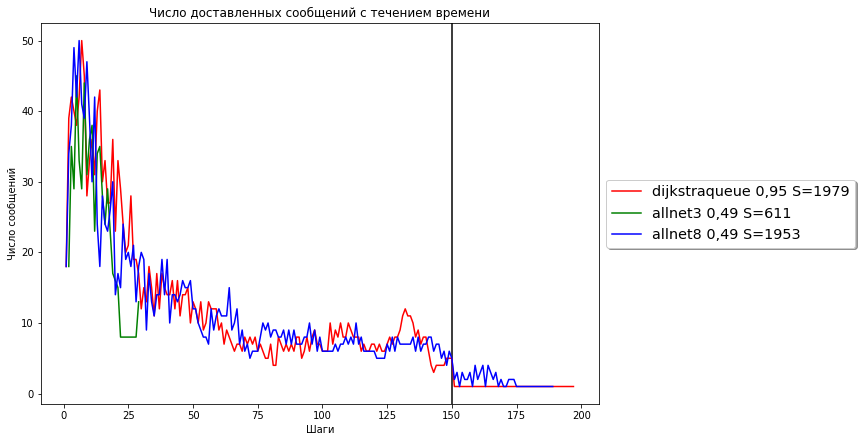

Доставлено 2412 Потеряно 98.7631% -dijkstraqueue 0,95
Доставлено 565 Потеряно 99.7103% -allnet3 0,49
Доставлено 2177 Потеряно 98.8836% -allnet8 0,49


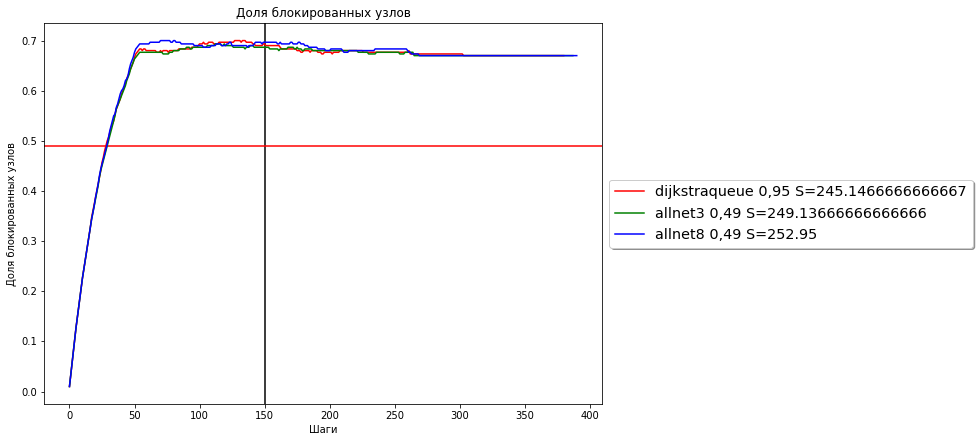

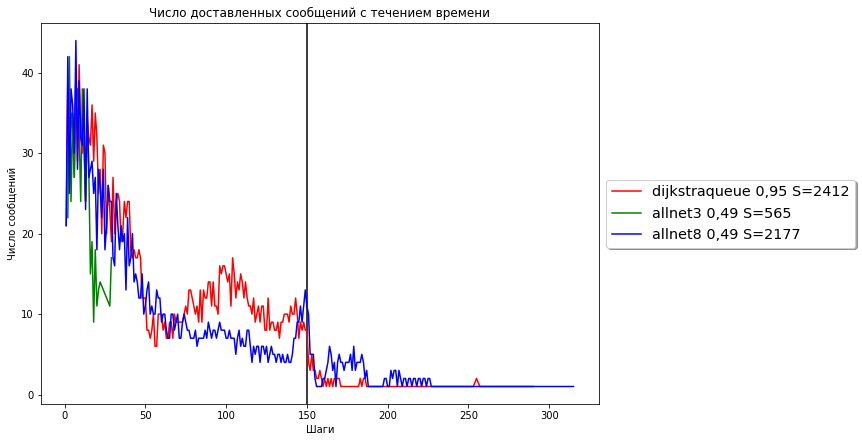

In [6]:
quantity = 300;
log_tags = [
{"tag":  "b17bda17-fc33-4bb6-b578-37c9f454ab11", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a3242104-3a10-4085-a808-31700a0ba74b", "label": "allnet3 0,49", "color": "green"},
{"tag":  "19294c90-87fa-474c-bbae-68058f01fcd9", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "701a2600-b3eb-4744-8c2e-80cceb53365b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "93bb4122-8426-4c39-a189-5b019d888614", "label": "allnet3 0,49", "color": "green"},
{"tag":  "d23d9bc2-c9a7-45bf-82e2-0b858b6f38c4", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "6c8f8681-66ad-44af-8e1e-3e07ebbb5a49", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "05d78035-2444-4536-8bb3-e34f8044a3bc", "label": "allnet3 0,49", "color": "green"},
{"tag":  "072bc1be-cf27-49fd-955c-d0839d0e647e", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "e7b9aa3d-8fe5-49f0-97ce-307ce92a5f66", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "490731f1-f176-4fe7-8a28-2283b06dd53f", "label": "allnet3 0,49", "color": "green"},
{"tag":  "8cda6659-3c95-4b80-acb3-35ff28b2247c", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

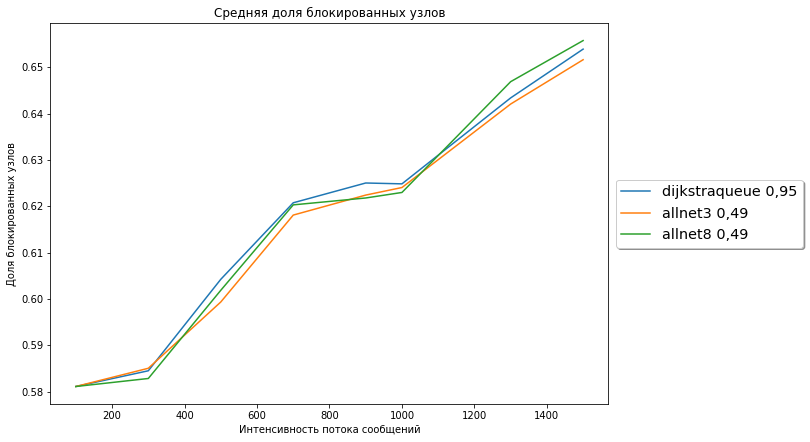

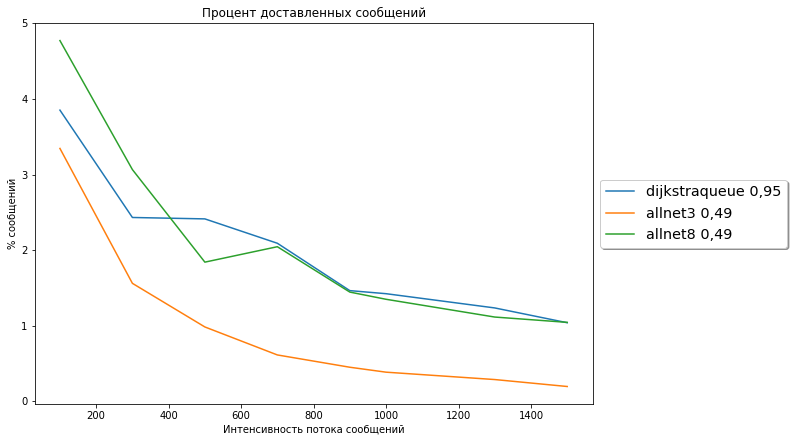

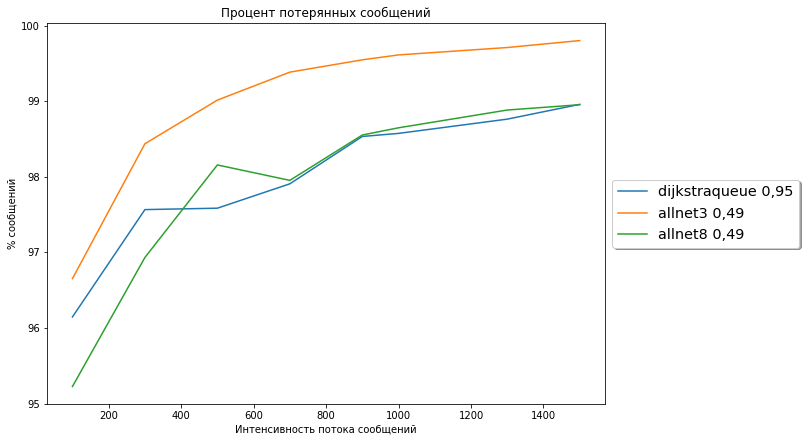

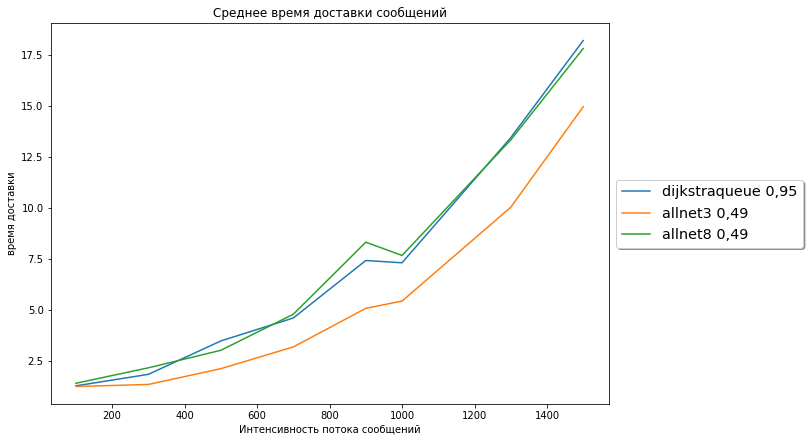

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.617263
allnet3 0,49          0.615510
allnet8 0,49          0.616734

dijkstraqueue 0,95    98.004646
allnet3 0,49          99.020422
allnet8 0,49          97.913812

dijkstraqueue 0,95    7.215989
allnet3 0,49          5.445443
allnet8 0,49          7.332012
